In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import math
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

<h1>Machine Learning Models </h1>

<h2>Reading data from file</h2>

In [3]:
data = pd.read_csv("final_features.csv")

In [4]:
data.head(2)

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,-0.108470,-0.172584,0.115508,0.165498,0.050041,0.104500,0.047697,-0.031508,0.253518,-0.018215
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-0.142902,-0.149380,-0.082208,-0.105020,-0.225894,0.029982,0.056607,-0.160301,0.197302,-0.089608


In [7]:
data.index[50]

51

In [8]:
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [9]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,-0.142902,-0.149380,-0.082208,-0.105020,-0.225894,0.029982,0.056607,-0.160301,0.197302,-0.089608
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,0.143160,-0.306466,-0.082052,-0.255014,-0.160884,0.154167,0.187339,-0.174920,-0.027716,-0.090748
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,-0.030402,-0.169257,-0.042085,-0.205133,0.041855,0.305579,0.271215,0.139906,0.173737,0.041718
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,-0.250071,-0.378713,0.207525,0.161997,0.047324,-0.273545,-0.028424,0.038811,-0.071177,0.260552
5,0.666656,0.571420,0.888879,0.799992,0.705878,0.705878,1.0,0.0,0.0,17.0,...,0.045780,0.083759,0.032969,0.068112,-0.009967,-0.223770,-0.094358,-0.005885,0.069878,0.104430


<h2>Random train test split( 70:30) </h2>

In [12]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [13]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283002, 625)
Number of data points in test data : (121287, 625)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6324857142857143 Class 1:  0.36751428571428574
---------- Distribution of output variable in train data ----------
Class 0:  0.3675 Class 1:  0.3675


In [14]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2>Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.887925715814872


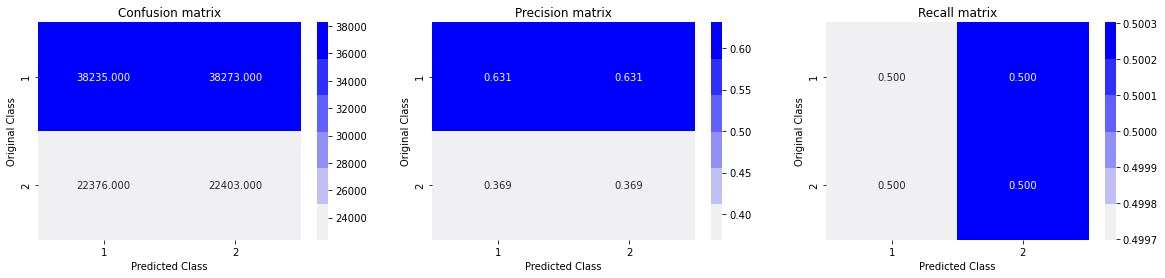

In [16]:
train_len = len(y_train)
test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2>Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4309483941071673
For values of alpha =  0.0001 The log loss is: 0.46779615855795026
For values of alpha =  0.001 The log loss is: 0.4592689039782545
For values of alpha =  0.01 The log loss is: 0.4231460779491513
For values of alpha =  0.1 The log loss is: 0.4381277796282625
For values of alpha =  1 The log loss is: 0.479033985334902
For values of alpha =  10 The log loss is: 0.5326628740406659


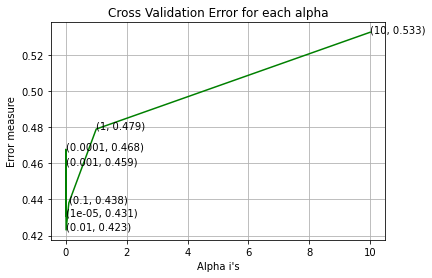

For values of best alpha =  0.01 The train log loss is: 0.42406599735455724
For values of best alpha =  0.01 The test log loss is: 0.4231460779491513
Total number of data points : 121287


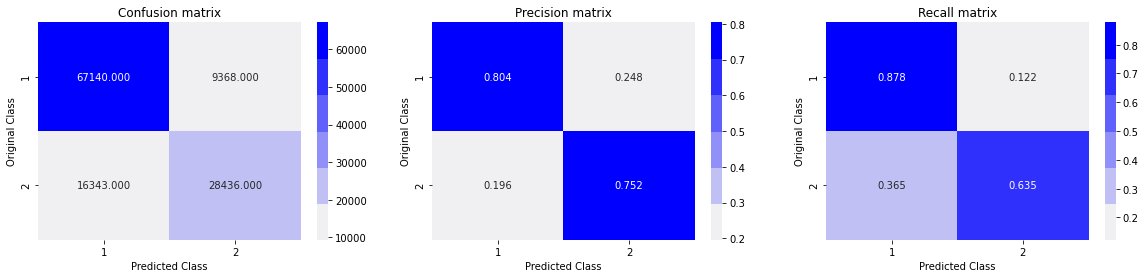

In [17]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.43837916365788976
For values of alpha =  0.0001 The log loss is: 0.4497285359156972
For values of alpha =  0.001 The log loss is: 0.4462385538734336
For values of alpha =  0.01 The log loss is: 0.4691691530089538
For values of alpha =  0.1 The log loss is: 0.4741125778098588
For values of alpha =  1 The log loss is: 0.5710262159511532
For values of alpha =  10 The log loss is: 0.6486974743113693


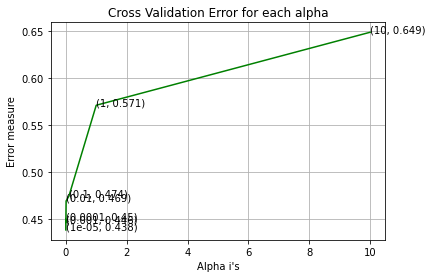

For values of best alpha =  1e-05 The train log loss is: 0.4358639577612978
For values of best alpha =  1e-05 The test log loss is: 0.43837916365788976
Total number of data points : 121287


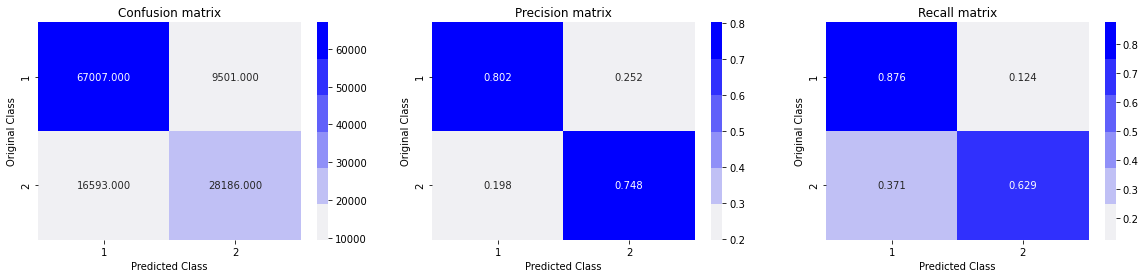

In [18]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)